# 10/24 Redoing (again) current restructure_data_compute_transports
## Clean nb, add function so that we only work with one dataset instead of a `ds` and a `mesh`

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [22]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
# dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [23]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [24]:
ds = mps.add_grid_info_coords(mesh,dss)

In [25]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [42]:
def open_transect_from_alg(ds, lats, lons, path, filename, geojson_file_name, tags, author):
    # get edge and vertex indices
    # lats= np.array([54, 60, 66, 64, 58])   
    # lons= np.array([302, 315, 310, 295, 296])
    
    LS_lats = np.append(lats, lats[0])
    LS_lons = np.append(lons, lons[0])
    
    # # calculate transects from algorithm, sort vertices & edges to be in consecutive order
    test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, ds)
    
    # from the transect, create a mask to capture the entire region specified by the transects
    # this will also output lats and lons corresponding to test_verts
    
        
    test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                                ds, 
                                                                                path,
                                                                                filename, 
                                                                                geojson_file_name,
                                                                                tags, 
                                                                                author)
    
    # use the dsMasks file to get the ACTUAL working vertices that you will need
    # this eliminates duplicate vertices that would occur if the transect moves back on itself
    # check that the vertices and edges from the mask are actually at the same plaaces...
    # in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
    # we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
    # is considered "inside the mask"
    
    alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(ds,dsMasks)

    return alg_edges, alg_vertices, dsMasks


In [43]:
path = './'
filename = 'SO_region_test'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

lats = np.array([-75,-50,-50,-75])
lons = np.array([250, 250, 350, 350])

alg_edges, alg_vertices, dsMasks = open_transect_from_alg(ds, lats, lons, path, filename, geojson_file_name, tags, author)

Creating geojson file from vertices identified with transect algorithm
Creating netcdf mask file from geojson file (vertices identified from transect algorithm)
SO_region_test_transect_from_alg.nc created and opened as dsMasks


ValueError: operands could not be broadcast together with shapes (58,) (0,) 

In [27]:
def open_from_mask(ds):
    # open mask of desired region (this is to find transects from a pre-existing mask)
    path = './'
    filename = 'LS_test_transect_from_mask'
    
    check_nc_existence = os.path.isfile(path + filename + '.nc')
    
    # check if .nc mask file exists
    if check_nc_existence == True:
        print(f'Opening {filename}.nc file as mask')
        mask = xr.open_dataset(path + filename + '.nc')
    else: 
        print('Creating .nc file')
        check_geojson_existence = os.path.isfile(path + filename + '.geojson')
    
        # convert LS_test.geojson to LS_test.nc mask file
        if check_geojson_existence == True:
            print(f'Using {filename}.geojson to create .nc file')
            fcMask = read_feature_collection(path + filename + '.geojson')
            # pool = create_pool(process_count=8)
            pool=None
            dsMasks = compute_mpas_region_masks(ds, fcMask, maskTypes =('cell',), pool=pool)
            dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
            mask = xr.open_dataset(path + filename + '.nc')
            print(f'{filename}.nc created and opened as masks')
        else:
            print(f'{filename}.geojson does NOT exist!')
    
    mask_edges, mask_vertices = find_and_sort_transect_edges_and_vertices(ds,mask)

    return mask_edges, mask_vertices, mask

### choose how you want to make transect and mask

In [28]:
# get edges and vertices of mask made from transect from algorithm
alg_edges, alg_vertices, dsMasks = mps.open_transect_from_alg(mesh)

# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks
Opening LS_test_transect_from_mask.nc file as mask


# Set up choice of coordinates

In [29]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

In [30]:
# xr_cellsOnTransectEdges, dss_transect_edges = mps.format_transect_data(ds,edges)

In [31]:
# dss_transect_edges_vIM = mps.calculate_velo_into_mask(dss_transect_edges, xr_cellsOnTransectEdges, ds, mask, edges)

In [32]:
# dss_transect_edges_vIM = mps.calculate_transport_into_mask(dss_transect_edges_vIM)

In [33]:
# dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_coords(dss_transect_edges_vIM, target_coords)

In [34]:
# def transport_in_density_space_from_ds(ds, edges, mask, target_coords):
#     xr_cellsOnTransectEdges , dss_transect_edges = mps.format_transect_data(ds, edges)
#     dss_transect_edges_vIM = mps.calculate_velo_into_mask(dss_transect_edges, xr_cellsOnTransectEdges, ds, mask, edges) 
#     dss_transect_edges_vIM = mps.calculate_transport_into_mask(dss_transect_edges_vIM)
#     dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_coords(dss_transect_edges_vIM, target_coords)

#     return dss_transect_edges_vIM, transport_transformed_cons

In [35]:
target_coords = np.linspace(1022,1029,100)
dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_space_from_ds(ds,edges, mask, target_coords)

In [36]:
total_transport_Edge = transport_transformed_cons.sum('nEdges').mean(dim=['xtime_startMonthly','TWO'])

In [37]:
total_transport_Edge

<xarray.DataArray 'transportIntoMask_Sv' (
                                          timeMonthly_avg_potentialDensity_EdgeP1: 99)> Size: 792B
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.11814745e-04,  3.06462676e-03,  1.57505889e-03,  4.20254698e-03,
        2.05194395e-03,  4.95288709e-03,  9.93161345e-04,  1.01291036e-03,
        1.01291036e-03,  1.99125188e-03,  7.10939408e-03,  1.57094650e-03,
        1.27624796e-03,  4.27928585e-03, -1.41471054e-03,  2.18573364e-03,
        8.88772354e-03,  3.81858455e-03,  2.19576675e-03,  1.20309819e-03,
        7.43518845e-03, -3.95514252e-03, -4.65895416e-03, -2.34028307e-03,
       -4.82400380e-03,  2.45107600e-03, -1.42451901e-02, -4.65206198e-03,
        3.25353153e-03, -2.76902108e-02,  4.97880185e-03, -1.42883699e-02,
       -1.58349450e-02, -3.22229260e-03, -5.50059543e-03, -1.33710401e-03,
        1.25608978e-03, -7.14738911e-04, -3.55302921e-03,  2.70828614e-03,
       -3.13269335e-03,  1.75314021e-02, -2.03268156e-02, -2.10116429e-02,
       -2.86544680e-03, -2.13914089e-02, -7.13234257e-02, -6.45584101e-02,
        3.35709891e-03, -2.78692258e-02,  1.69865397e-03, -3.99142020e-02,
        4.20030751e-02, -8.00100244e-02, -1.65532998e-01, -6.11424876e-02,
       -1.17347906e-01, -6.36429723e-02, -8.71263665e-02,  3.87897153e-02,
       -2.13466777e-03,  1.55541966e-01,  2.49274528e-01,  2.63659045e-01,
        2.69498586e-01,  7.41909085e-01,  8.74018639e-01,  1.33087485e+00,
        2.37879014e-01, -1.50154099e-01, -3.71547955e+00,  5.35322584e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
Coordinates:
    simulationStartTime                      |S64 64B b'0001-01-01_00:00:00'
  * timeMonthly_avg_potentialDensity_EdgeP1  (timeMonthly_avg_potentialDensity_EdgeP1) float64 792B ...

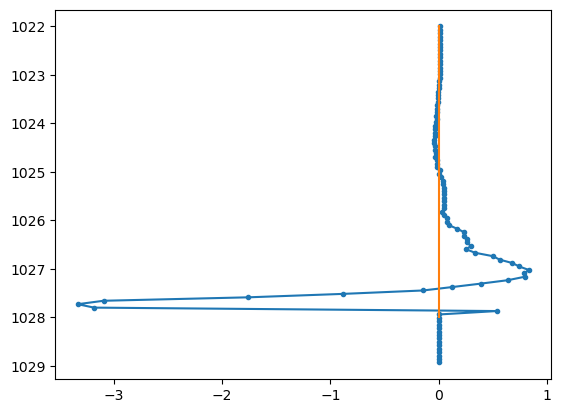

In [38]:
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_coords[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))